In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm

# Again asking the question, are clinvar variants that are in amino acids that are near glycosites more likely to be pathogenic than ones that are not, but now with continuous values

In [6]:
path_dct = {'benign':1,
            'likely benign':2,
            'likely pathogenic':3,
            'pathogenic':4}

In [7]:
df = pd.read_csv('../data/clinvar_glycoproteins_distances.txt',
                 sep='\t',
                index_col=0)
df = df.sort_values(by='clinvar_path')
df['clinvar_path_val'] = [path_dct[c] for c in df['clinvar_path']]
df['log_distance'] = np.log10(df['distance_to_feature'])

Text(0, 0.5, 'log10(distance to N-Gly)')

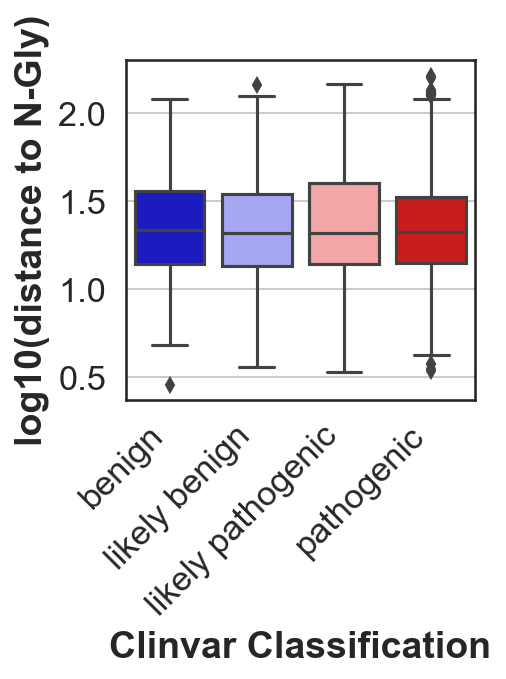

In [8]:
sns.set_context("paper")
    
# Set the font to be serif, rather than sans
sns.set(font='arial',font_scale=1.5)

# Make the background white, and specify the
# specific font family
sns.set_style("white", {
    "font.family": "arial",'axes.grid': True,"font.size":14,"axes.labelsize":14})

plt.figure(dpi=150,figsize=(3,3))
df = df.sort_values(by='clinvar_path')
sns.boxplot(x='clinvar_path',
            y='log_distance',
            data=df,
            palette='seismic',)
plt.xlabel('Clinvar Classification',fontweight='bold')
plt.xticks(rotation='45',ha='right')
plt.ylabel('log10(distance to N-Gly)',fontweight='bold')

In [5]:
formula = 'clinvar_path_val ~ distance_to_feature'

model = smf.ols(formula=formula, data=df).fit()

In [6]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       clinvar_path_val   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.455
Date:                Fri, 27 Mar 2020   Prob (F-statistic):              0.117
Time:                        10:38:09   Log-Likelihood:                -4542.5
No. Observations:                3306   AIC:                             9089.
Df Residuals:                    3304   BIC:                             9101.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               3.5215      0.026    136.668      0.000       3.471       3.572
distance_to_feature    -0.0010      0.001     -1.567      0.117      -0.002       0.000
==============================================================================
Omnibus:                      948.707   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2002.262
Skew:                          -1.733   Prob(JB):                         0.00
Kurtosis:                       4.589   Cond. No.                         60.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Looking at relationships on a per amino acid change level

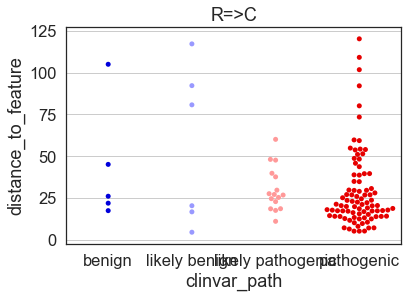

/Users/d/work/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1620: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


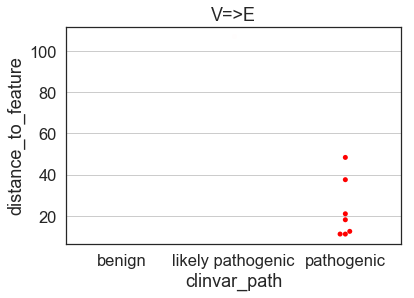

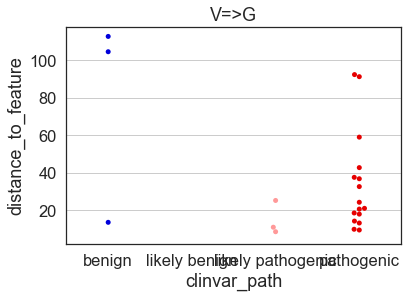

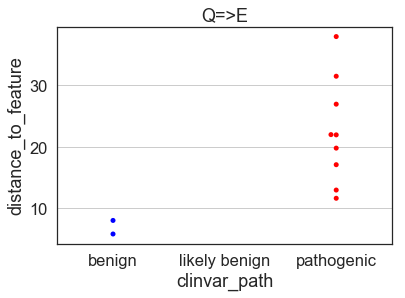

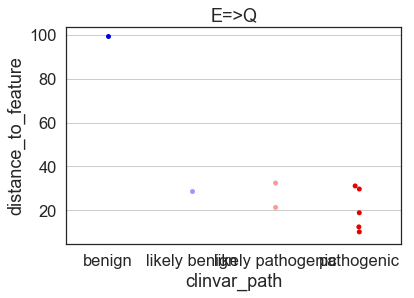

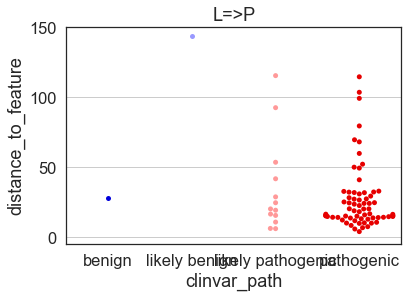

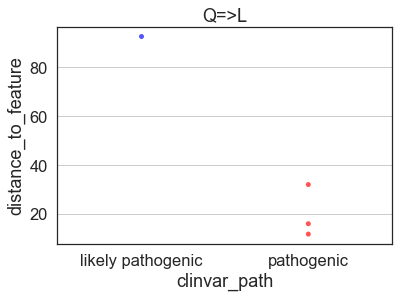

In [26]:
for ac in df['aa_change'].unique():
    aa_df = df[df['aa_change'] == ac]
    
    if aa_df.shape[0] < 3 or len(aa_df['clinvar_path'].unique()) < 2:
        continue
        
    formula = 'clinvar_path_val ~ distance_to_feature'

    model = smf.ols(formula=formula, data=aa_df).fit()  
    p = model.pvalues['distance_to_feature']
    
    if p < 0.1:
        
        sns.swarmplot(x='clinvar_path',
                        y='distance_to_feature',
                        data=aa_df,
                        palette='seismic',)

        plt.title(ac)
        plt.show()

## Looking on a per class basis

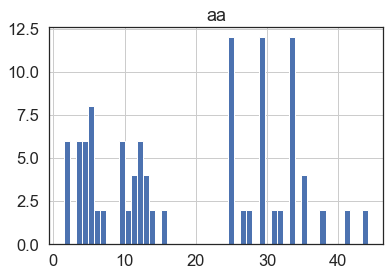

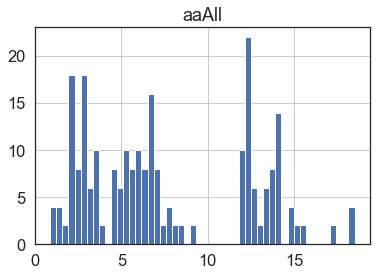

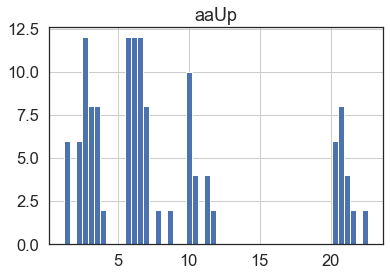

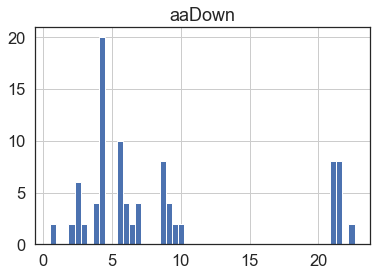

In [53]:
gi_df = pd.read_csv('../data/glyco_impact.1.csv')
gi_df['aa_change'] = gi_df['Var1'] + '=>' + gi_df['Var2']
gi_df_copy = gi_df.copy()
gi_df_copy['aa_change'] = gi_df_copy['Var2'] + '=>' + gi_df_copy['Var1']

gi_df = pd.concat([gi_df,gi_df_copy])

for gi_type in ['aa','aaAll','aaUp','aaDown']:
    one_gi = gi_df[gi_df['v1_type'] == gi_type]
    plt.hist(one_gi['glyco_dist'],50)
    plt.title(gi_type)
    plt.show()

In [54]:
high_gi_thresh = {'aa':20,
                 'aaAll':10,
                 'aaUp':15,
                 'aaDown':15}

In [55]:
merged = gi_df.merge(df,how='outer',on='aa_change')

0.825272982903659


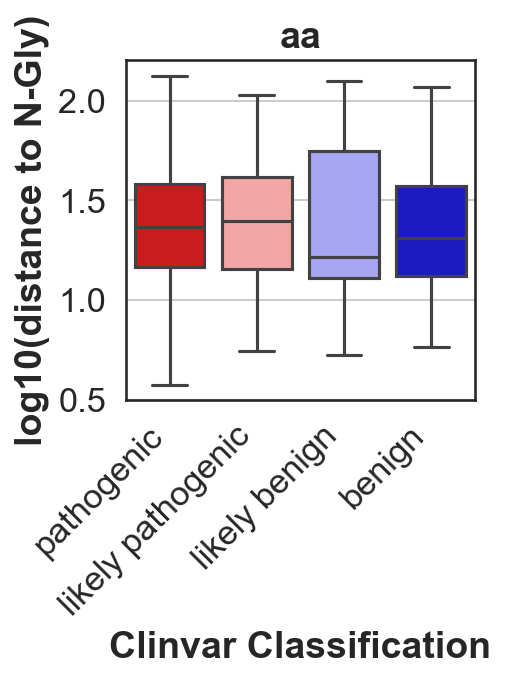

0.6489811401660084


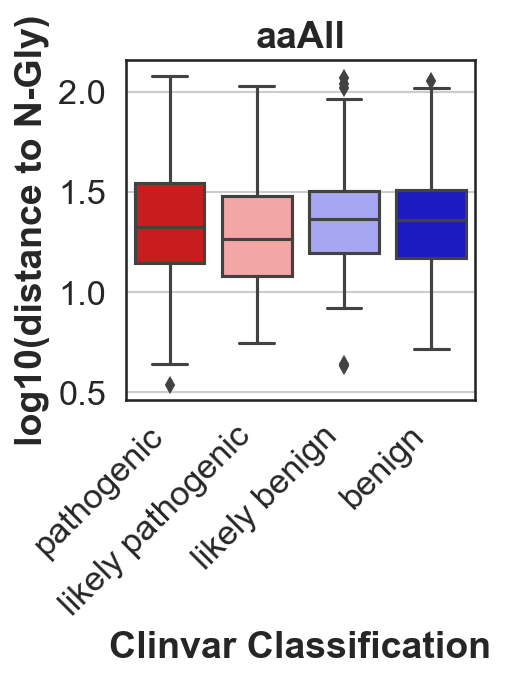

0.16628898774010614


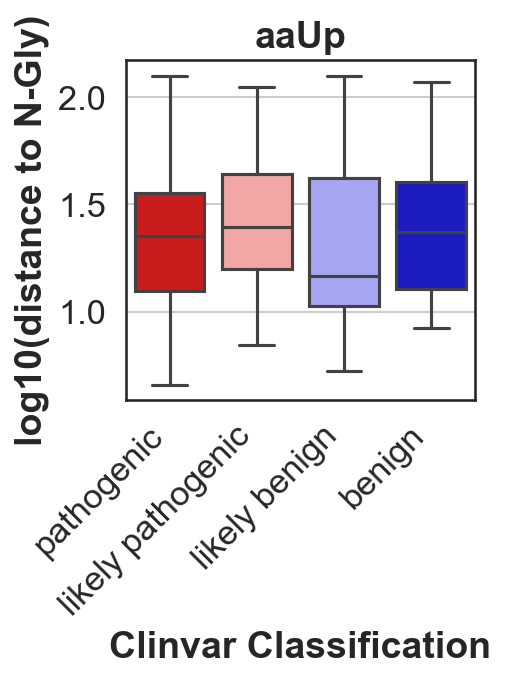

0.004783783229119515


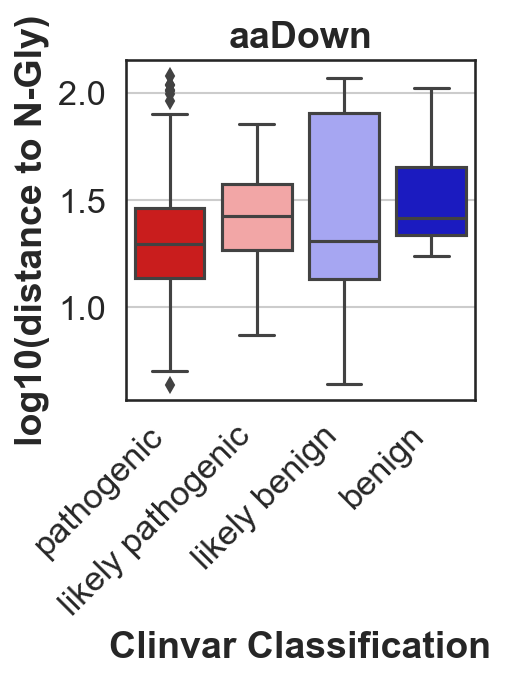

In [59]:
lst_ = []

for gi_type in ['aa','aaAll','aaUp','aaDown']:
    
    one_gi = merged[merged['v1_type'] == gi_type]
    high_gi = one_gi[one_gi['glyco_dist'] > high_gi_thresh[gi_type]]
    
    lst_.append(high_gi)
    
    formula = 'clinvar_path_val ~ distance_to_feature'
    
    model = smf.ols(formula=formula, data=high_gi).fit()  
    p = model.pvalues['distance_to_feature']
    print(p)
    plt.figure(dpi=150,figsize=(3,3))
    sns.boxplot(x='clinvar_path',
                    y='log_distance',
                    order=['pathogenic','likely pathogenic', 'likely benign', 'benign'],
                    data=high_gi,
                    palette='seismic_r',)

    plt.title(gi_type,fontweight='bold')
    plt.xlabel('Clinvar Classification',fontweight='bold')
    plt.xticks(rotation='45',ha='right')
    plt.ylabel('log10(distance to N-Gly)',fontweight='bold')
    plt.show()

In [61]:
concat_df = pd.concat(lst_,axis=0)
concat_df

,Unnamed: 0,Var1,Var2,value,v1,v2,glyco_dist,v1_type,v2_type,aa_change,aa,protein,clinvar_path,clinvar_index,distance_to_feature,clinvar_path_val,log_distance
283,63.0,C,F,-2.0,C_aa,F_aa,33.742783,aa,aa,C=>F,528.0,O60500,likely pathogenic,17442.0,30.83,3.0,1.488974
284,63.0,C,F,-2.0,C_aa,F_aa,33.742783,aa,aa,C=>F,417.0,O60500,likely pathogenic,17448.0,NaN,3.0,NaN
285,63.0,C,F,-2.0,C_aa,F_aa,33.742783,aa,aa,C=>F,623.0,O60500,likely pathogenic,17432.0,5.54,3.0,0.743510
286,63.0,C,F,-2.0,C_aa,F_aa,33.742783,aa,aa,C=>F,318.0,P61812,likely pathogenic,2406.0,39.71,3.0,1.598900
287,63.0,C,F,-2.0,C_aa,F_aa,33.742783,aa,aa,C=>F,65.0,O00300,likely pathogenic,33067.0,11.06,3.0,1.043755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6604,950.0,R,C,-3.0,R_aaDown,C_aaDown,21.346976,aaDown,aaDown,C=>R,774.0,Q96KG7,pathogenic,28212.0,NaN,4.0,NaN
6605,950.0,R,C,-3.0,R_aaDown,C_aaDown,21.346976,aaDown,aaDown,C=>R,127.0,P01008,pathogenic,1836.0,4.35,4.0,0.638489
6606,950.0,R,C,-3.0,R_aaDown,C_aaDown,21.346976,aaDown,aaDown,C=>R,928.0,P25092,pathogenic,7046.0,NaN,4.0,NaN
6607,950.0,R,C,-3.0,R_aaDown,C_aaDown,21.346976,aaDown,aaDown,C=>R,49.0,Q12809,pathogenic,32131.0,98.66,4.0,1.994141


Text(0, 0.5, 'log10(distance to N-Gly)')

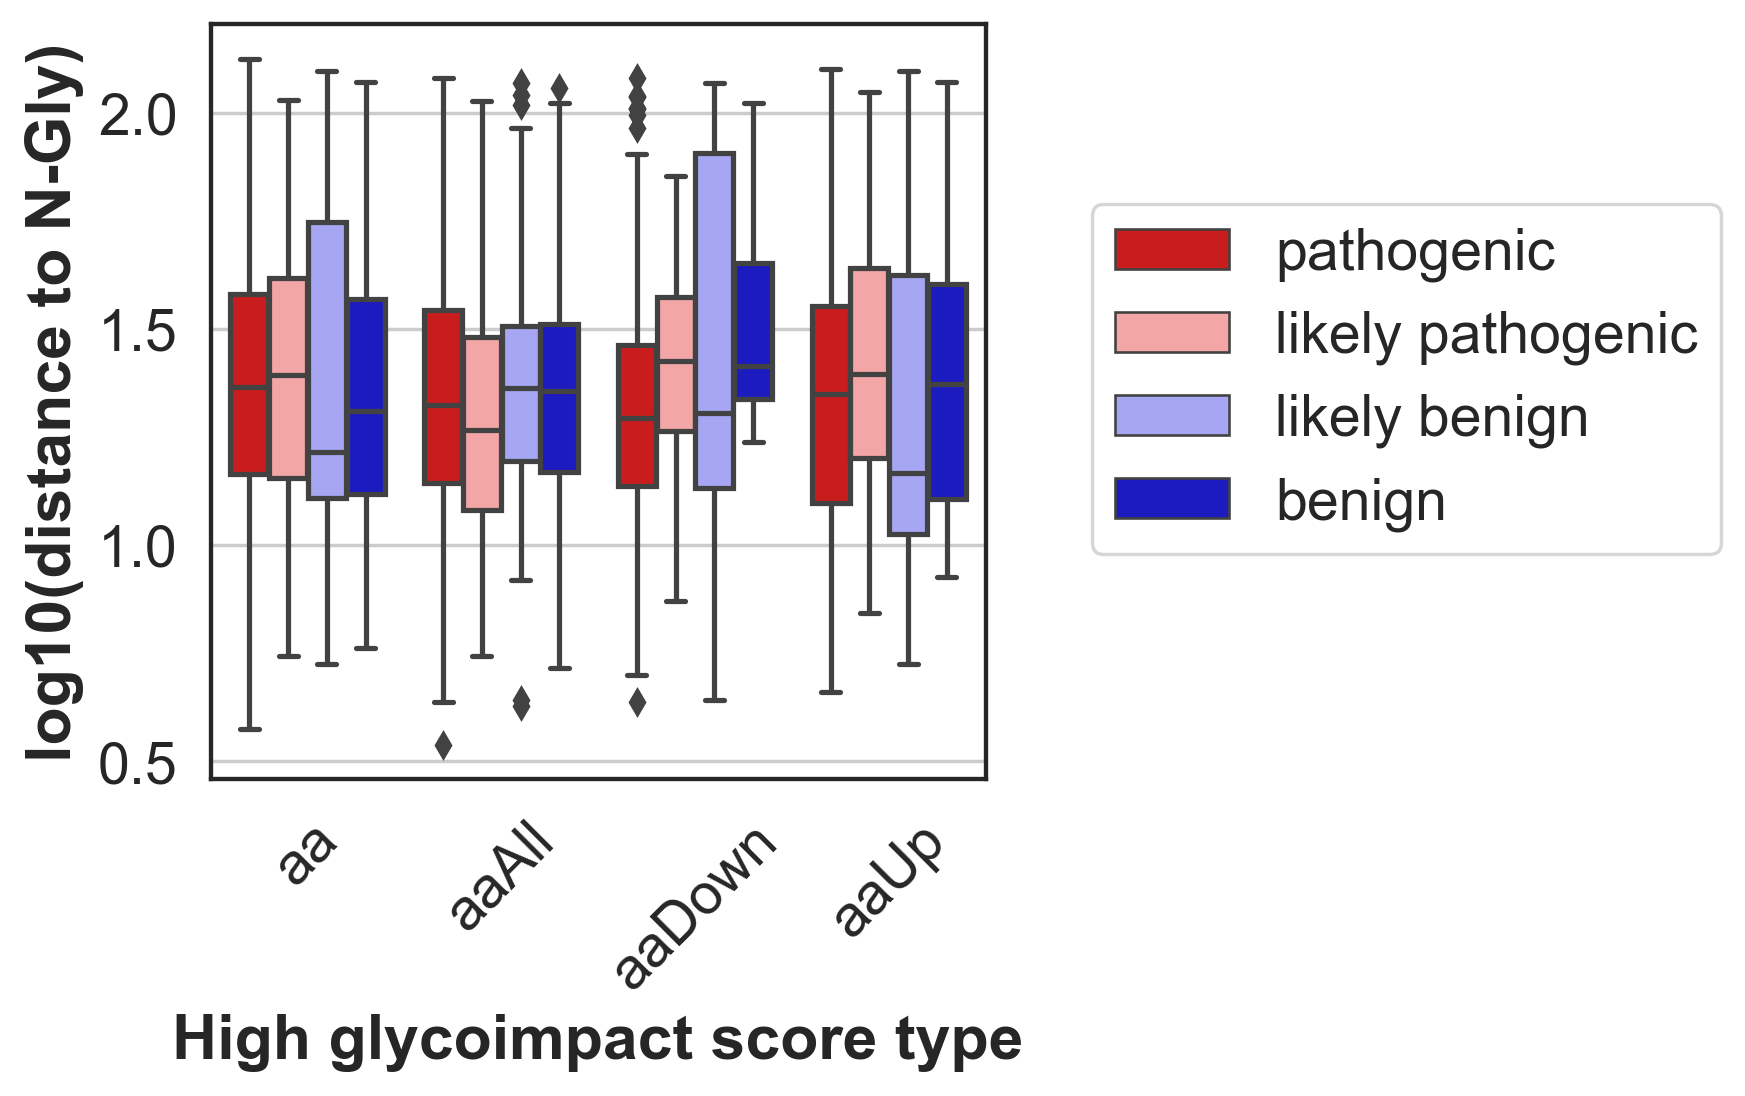

In [62]:
plt.figure(dpi=250,figsize=(4,4))
concat_df = concat_df.sort_values(by='v1_type')
sns.boxplot(data=concat_df,
               x='v1_type',
               y='log_distance',
               palette='seismic_r',
               hue_order=['pathogenic','likely pathogenic', 'likely benign', 'benign'],
               hue='clinvar_path')
plt.legend(bbox_to_anchor=(1.1,0.8))
plt.xticks(rotation='45')
plt.xlabel('High glycoimpact score type',fontweight='bold')
plt.ylabel('log10(distance to N-Gly)',fontweight='bold')

## Now looking generally at counts that belong to each category

In [19]:
table = concat_df.groupby(by=['clinvar_path','GI_PI_type'],as_index=False).count()[['clinvar_path','GI_PI_type','aa']]

In [20]:
pivot_table = table.pivot(columns='GI_PI_type',values='aa',index='clinvar_path').fillna(0)

In [21]:
pivot_table.loc['all_path'] = pivot_table.loc['likely pathogenic'] + pivot_table.loc['pathogenic']
pivot_table.loc['all_benign'] = pivot_table.loc['likely benign'] + pivot_table.loc['benign']

In [22]:
pivot_table

GI_PI_type,High GI and negligible PI,High and Medium GI and negligible PI,Low GI and negligible PI
clinvar_path,,,
benign,7,69,82
likely benign,7,56,69
likely pathogenic,7,41,60
pathogenic,36,270,343
all_path,43,311,403
all_benign,14,125,151


In [23]:
test_rows = [['benign','pathogenic'],
             ['all_benign','all_path']]
test_cols = [['High GI \nand negligible PI','Low GI \nand negligible PI'],
             ['High and Medium GI \nand negligible PI','Low GI \nand negligible PI']]

## Fisher Exact:

In [24]:
for col in test_cols:
    for row in test_rows:
        cont_table = pivot_table[col].loc[row]
        odds,p = scipy.stats.fisher_exact(cont_table)
        print(cont_table)
        print()
        print('p = {}'.format(p))
        print()

GI_PI_type    High GI \nand negligible PI  Low GI \nand negligible PI
clinvar_path                                                         
benign                                  7                          82
pathogenic                             36                         343

p = 0.8382917079642018

GI_PI_type    High GI \nand negligible PI  Low GI \nand negligible PI
clinvar_path                                                         
all_benign                             14                         151
all_path                               43                         403

p = 0.7550528867471792

GI_PI_type    High and Medium GI \nand negligible PI  \
clinvar_path                                           
benign                                            69   
pathogenic                                       270   

GI_PI_type    Low GI \nand negligible PI  
clinvar_path                              
benign                                82  
pathogenic                          

In [25]:
pivot_table[test_cols[0]].loc[test_rows[0]]

GI_PI_type,High GI and negligible PI,Low GI and negligible PI
clinvar_path,,
benign,7,82
pathogenic,36,343
